# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (2da entrega)

## Fecha de entrega:

27/5/2024

## Integrantes

* <Rode, Valentin>
* <Gonzalez, Leonardo>
* <Córsico, Justo>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) (con las celdas ejecutas) y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

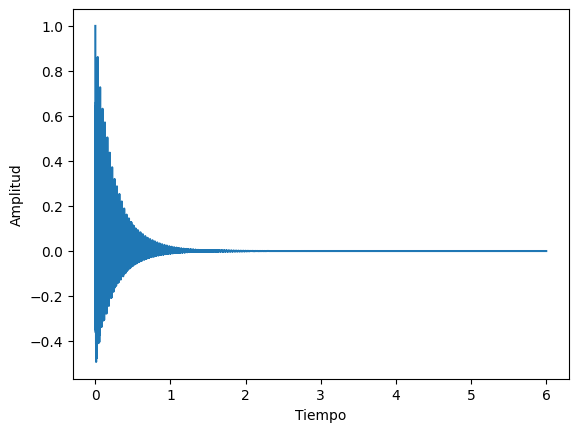

In [1]:
import numpy as np
import soundfile as sf
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.io.wavfile import write
from defs import get_plot
from tkinter import *
from IPython.display import clear_output, display
from tkinter import filedialog
import simpleaudio
from LeerArchivos import normalizacion, cargar_archivos
from GenerarRI import get_signalwav
import sounddevice as sd

## Descargar dataset
El objetivo es tener archivos para validar el software creado , para lo cual es necesario contar con la información y los datos de la medición.

### 1. Respuestas al impulso: 
**Consigna:** Descargar **al menos dos** respuestas al impulso (RI o en ingles IR, Impulse Responses) de dos recintos distintos del siguiente [link](https://www.openair.hosted.york.ac.uk/?page_id=36) y toda la información relevante de la medición, ademas de los resultados de los parametros acústicos calculados (para luego comparar). También se pueden usar los archivos dispuestos en el Drive de la asignatura. 

### 2. Sine sweep logarítmico + filtro inverso: 
**Consigna:** Descargar **al menos un** sine sweep con su respectivo filtro inverso. Una posibildiad es usar los archivos dispuestos en el GDrive de la asignatura. Para generar el filtro inverso usar la info brindada por el informe técnico en la misma carpeta de los archivos. 

## Función de carga de archivos de audio

**Consigna:** realizar una función que permita cargar archivos de audio, en lo posible \*.wav, por ejemplo los archivos anteriormente descargados. Contemplar el ingreso de más de un archivo de audio, por tipo.

In [2]:
def cargar_archivos():
    """
    Carga archivos de audio WAV seleccionados por el usuario.

    Devuelve:
        (list): Lista de rutas de archivos WAV seleccionados.
    """

    archivo_usuario = []
    mas_archivos = 'y'
    while mas_archivos == 'y':

        archivo_usuario.append(input('Ingrese la ruta del archivo: '))

        mas_archivos = input('¿Desea cargar otro archivo? [y/n]: ')

    print(archivo_usuario)

    return archivo_usuario

def cargar_wav(file):
    """
    Carga datos de audio WAV desde un archivo especificado.

    Args:
        file (str): Ruta del archivo WAV.

    Devuelve:
        (tuple): Tupla que contiene datos de audio (data) y frecuencia de muestreo (fs).
    """
    
    data, fs = sf.read(file)
    return(data, fs)

def normalizacion(ir_data):
    """
    Normaliza los datos de audio (impulse response) a valores entre -1 y 1.

    Args:
        ir_data (ndarray): Matriz de datos de audio (impulse response).

    Devuelve:
        (ndarray): Matriz de datos de audio normalizada.
    """
    ir = ir_data.astype(np.float32)  # Or another appropriate data type


    # Normalize data
    ir = ir / np.max(np.abs(ir))  # Normalize using absolute values
    
    return ir


        



Llamar a la función con uno de los ejemplos anteriormente descargados y usar la función de visualización de la 1er entrega.

['C:\\Users\\Justo\\Desktop\\SegundaEntrega\\Mono.wav', 'C:\\Users\\Justo\\Desktop\\SegundaEntrega\\Mono2.wav']


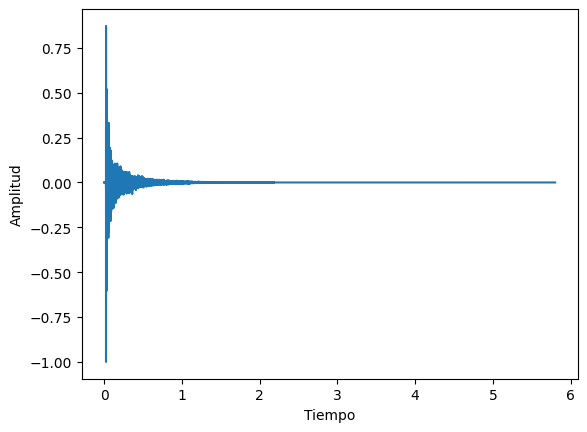

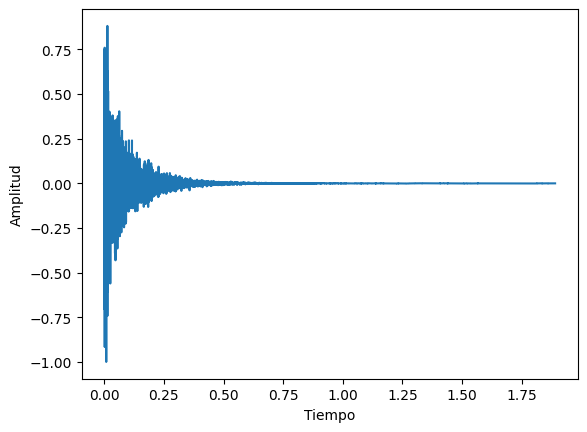

In [3]:
# C:\Users\Justo\Desktop\SegundaEntrega\Mono.wav
# C:\Users\Justo\Desktop\SegundaEntrega\Mono2.wav

if __name__ == '__main__':
    archivo_usuario = cargar_archivos()

    for i in range(len(archivo_usuario)):
        data, fs = cargar_wav(archivo_usuario[i])
        ir_norm = normalizacion(data)
        t = np.linspace(0, (len(ir_norm))/fs, (len(ir_norm)))
        get_plot(t, ir_norm)


> **Opcional**: el código de la siguiente celda genera un botón de selección (ver los pasos de instalación [aqui](https://ipywidgets.readthedocs.io/en/latest/user_install.html)), y guarda las rutas a los archivos seleccionados en la variable files. La función desarrollada debería tomar las rutas y leer el contenido de los archivos, utilizando alguna de las librerías vistas en clase.

In [ ]:
# from ipywidgets import Button
# from tkinter import Tk, filedialog
# from IPython.display import clear_output, display
# files = []
# def select_files(b,files=files):
#     clear_output()
#     root = Tk()
#     root.withdraw() # Hide the main window.
#     root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
#     files.append(filedialog.askopenfilename()) # List of selected files will be set button's file attribute.
#     print(files) # Print the list of files selected.

# fileselect = Button(description="Seleccione el archivo")
# fileselect.on_click(select_files)

# display(fileselect)
# files

## Función de sintetización de respuesta al impulso

**Consigna:** realizar una función para sintetizar una respuesta al impulso. La misma recibira como parametro el $T60$ que se desea obtener, y deberá sintetizar una respuesta al impulso considerando las frecuencias centrales de banda de octava y tercio de octava como establece la norma IEC61260 (IEC61260,1995). La siguiente ecuación define una RI, para una frecuencia central $f_{i}$:

\begin{equation}
y_{i}=A_{i}e^{-\tau_it}\cos(2πf_{i}t)
\tag{6}
\end{equation}

donde $A_{i}$ es el coeficiente de amplitud para esa $f_{i}$(puede ser 1), y  $π_{i}$ define el decaimiento exponencial en función de $T_{60_i}$ (tiempo de reverberación) para una frecuencia $f_{i}$.

\begin{equation}
\tau_i=-\frac{ln(10^{-3})}{T_{60_i}}
\tag{7}
\end{equation}

La suma de varias frecuencias centrales $f_{i}$ se define como:
\begin{equation}
  y=\sum_{y=1}^{n}y_{i}
\tag{8}
\end{equation}

Con $n$ la cantidad de frecuencias centrales $f_{i}$ del filtro. La funcion debe recibir el tiempo de reverberacion para cada frecuencia, y devolver la respuesta al impulso correspondiente como un archivo de audio .wav. Al momento de definir la función, buscar la forma de que la misma permita varios $T60_i$ para cada frecuencia. 

> Con esta funcion se busca obtener un archivo de audio de valores de $T60_i$ conocidos que permita probar el software.

Llamar a la función con un vector que contega varios $T60$ para las cada frecuencias centrales $f_{i}$.

In [3]:
def IR_sint(t, f_i, RT_i, tiempo_impulso, frec_muestreo):
    
    
    tau_i = np.log(10**(-3))/RT_i
    y_i = (np.exp(tau_i*t))*np.cos(2*np.pi*f_i*t)

    return y_i

# Main

tiempo_impulso=6
frec_muestreo=44100
t = np.linspace(0, tiempo_impulso, tiempo_impulso*frec_muestreo)

# Bandas de Octava según IEC 61260
nominal_frec = [31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
# Genero un vector con T60i para cada frecuencia con los datos de Openair.com, Usina del Arte Symphony Hall 
RT_xfrec_list = [2.15, 1.48, 1.63, 1.91, 2.08, 2.09, 1.82, 1.6, 1.18, 1.11]
RT_xfrec_list2 = [10, 10, 10, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
RT_xfrec_list3 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

decay = []

for i in range(len(nominal_frec)):
    decay.append(IR_sint(t, nominal_frec[i], RT_xfrec_list[i], tiempo_impulso, frec_muestreo))

impulso = sum(decay)

# Normalizado
norm_impulse = normalizacion(impulso) 

name = input('Nombrar archivo wav: ')
def get_signalwav(señal, frec_muestreo, name):
    audio1 = (señal * np.iinfo(np.int16).max).astype(np.int16)
    wavfile.write(name + '.wav', frec_muestreo, audio1)

get_signalwav(norm_impulse, frec_muestreo, name)

Llamar la función de visualizar el dominio temporal, de la entrega anterior.

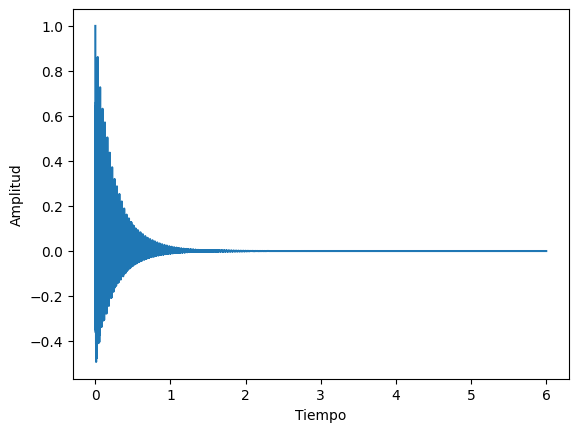

In [4]:
get_plot(t, norm_impulse)


Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

<img src="impulso_sint_espectro.png">

Reproducir señal resultante.

In [6]:
sd.play(norm_impulse)
sd.wait

<function sounddevice.wait(ignore_errors=True)>

Comentar sobre el resultado obtenido, ¿Es una buena aproximación? ¿Qué aspectos estamos dejando de lado en esta sintetización, que en un caso real estan presentes?.

...


## Función obtener respuesta al impulso

**Consigna:** realizar una función que permita obtener la respuesta al impulso en formato de señal de audio .wav, a partir del sinesweep logarítmico grabado y el filtro inverso generado utilizando el siguiente método: 

Supongamos que un recinto es excitado por una señal sinesweep logarítmica $x(t)$ y captada por un micrófono $y(t)$ y buscamos la RI del recinto $h(t)$, lo anterior se expresa de la siguiente manera:

\begin{equation}
y(t)=x(t)*h(t)
\tag{9}
\end{equation}

Para un sine sweep lineal (que no es nuestro caso) el problema es sencillo, pero en nuestro caso (sine sweep logarítmico) requiere trabajar un poco respecto $x(t)$ para obtener la siguiente expresión:

\begin{equation}
h(t) = F^{-1}[H(jw)]=F^{-1}[Y(jw)K(jw)]
\tag{10}
\end{equation}

Recordar que $k(t)$ es el filtro inverso (ecu.5) y $K(jw)$ su respectiva transformada de fourier. De esta manera se obtiene la respuesta al impulso buscada.

> El desarrollo matemático de la anterior expresión se encuentra en el [Anexo I - Obtener la respuesta al impulso a partir de un sine sweep](../consigna_TP_matlab.pdf) (p.14) del instructivo para Matlab del TP.

Llamar a la función con un sine sweep y su respectivo filtro inverso creados con la función de la primer entrega (**no** los descargados).

In [7]:
def obtenerRI(archivo_usuario):
    """
    Calcula la respuesta al impulso (RI) a partir de un archivo de seno y su inverso.

    Args:
        archivo_usuario (list): Lista con dos rutas de archivos:
            - Archivo de seno.
            - Archivo de filtro inverso.

    Devuelve:
        (tuple): Tupla que contiene la respuesta al impulso (RI) y la frecuencia de muestreo (fs).
    """
    read_sine, fs = sf.read(archivo_usuario[0])
    read_inv_filt, fs = sf.read(archivo_usuario[1])
    imp_res = signal.fftconvolve(read_sine, read_inv_filt, mode='full')
    return imp_res, fs

def imp_wav(señal, frec_muestreo, name):
    """
    Guarda una señal de audio normalizada en un archivo WAV.

    Args:
        señal (ndarray): Matriz de datos de audio.
        frec_muestreo (int): Frecuencia de muestreo en Hz.
        name (str): Nombre del archivo WAV a generar.
    """
    audio1 = (señal * np.iinfo(np.int16).max).astype(np.int16)
    wavfile.write(name + '.wav', frec_muestreo, audio1)

# Main

archivo_usuario = [r'X:\UnTreF\Python\TPgit\SegundaEntrega\filtro_inverso.wav', r'X:\UnTreF\Python\TPgit\SegundaEntrega\Toma_n1_a-03.wav']

filtro_inverso = 'Filtro inversoGENERADO.wav'
sine_sweep = 'Sine SweepGENERADO.wav'
imp_res, fs = obtenerRI(archivo_usuario)
imp_res_norm = normalizacion(imp_res)
t = np.linspace(0, (len(imp_res))/fs, (len(imp_res)))
name = input('Nombrar archivo wav: ')
imp_wav(imp_res_norm, fs, name)


LibsndfileError: Error opening 'X:\\UnTreF\\Python\\TPgit\\SegundaEntrega\\filtro_inverso.wav': System error.

Visualizar la señal con la función creada en la primer entrega.

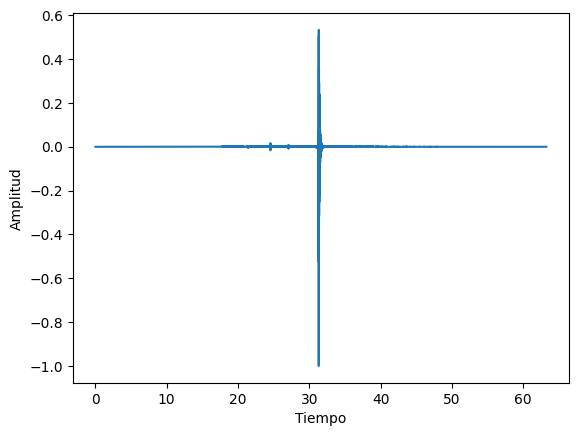

In [ ]:
get_plot(t, imp_res_norm)

Reproducir señal resultante.

In [ ]:
sd.play(imp_res_norm) # Hay que esperar 30 segundos para que suene el impulso
sd.wait

<function sounddevice.wait(ignore_errors=True)>

Comentar sobre el resultado obtenido. ¿Qué es lo que se esta escuchando? Realizar el mismo procedimiento con la señal descargada y el filtro inverso generado (para dicho sine sweep)

*completar*

Mencionar aspectos que diferencian los impulso generados en esta función, con los sintetizados.

*completar*

## Función filtros norma IEC61260

**Consigna**: Realizar una función que filtre todas las señales en octavas y tercio de octava según la norma IEC61260, con el objetivo de calcular los parámetros acústicos discriminando las frecuencias. 

Para lo cual utilizar las funciones del modulo [signals de scipy](https://docs.scipy.org/doc/scipy/reference/signal.html). Se adjunta el código capaz de calcular los coeficientes del filtro y aplicarlos a una señal. La función debe completarse con el código necesario para que este proceso se repita para cada una de las frecuencias centrales determinadas en la norma. Así mismo, el primer argumento de la función [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) determina el grado del filtro. Evaluar el valor del mismo para que la frecuencia central de la banda coincida con las especificadas en la norma.

> Para ver una introducción breve a la implementación de filtros, usar el siguiente [documento](https://github.com/maxiyommi/signal-systems/blob/master/material_extra/Filtros/intro_filtros.ipynb).

Llamar a la función con alguna RI generada anteriormente.

In [ ]:
frecuencia_muestreo=44100
#Octava - G = 1.0/2.0 / 1/3 de Octava - G=1.0/6.0
def filtrar_frec(centerFrequency_Hz,G,i):
    """
    Calcula y aplica un filtro de banda o de tercio de octava a una señal de audio.

    Args:
        centerFrequency_Hz (float): Frecuencia central del filtro en Hz.
        G (float): Factor de ganancia del filtro (1/2 para banda, 1/6 para tercio de octava).
        i (int): Índice de la banda o tercio de octava (para numeración interna).

    Devuelve:
        None: No se devuelve ningún valor, pero se guardan los resultados en archivos WAV.
    """
    factor = np.power(2, G)
    #Calculo los extremos de la banda a partir de la frecuencia central
    lowerCutoffFrequency_Hz=centerFrequency_Hz/factor
    upperCutoffFrequency_Hz=centerFrequency_Hz*factor
    if upperCutoffFrequency_Hz >= (frecuencia_muestreo/2):
        upperCutoffFrequency_Hz = (frecuencia_muestreo/2)-1
    print('Frecuencia de corte inferior: ', round(lowerCutoffFrequency_Hz), 'Hz')
    print('Frecuencia de corte superior: ', round(upperCutoffFrequency_Hz), 'Hz')

    #Extraemos los coeficientes del filtro 
    sos = signal.iirfilter(4, [lowerCutoffFrequency_Hz,upperCutoffFrequency_Hz],rs=60, btype='band', analog=False,ftype='butter', fs=frecuencia_muestreo, output='sos') 
    audiodata,fs=sf.read("Mono.wav")
    filt = signal.sosfilt(sos, audiodata)
    nombre_archivo=f"impulso filtrado tercio{i}.wav"
    sf.write(nombre_archivo,filt,fs)

frec_centrales_octava=(31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000,16000)
frec_centrales_tercio=(25,31.5,40,50,63,80,100,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000,10000,12500,16000,20000)
tipo_octava=str(input("Ingrese tipo de filtro(tercio/banda): "))
if tipo_octava=="banda":
    G=1/2
    octava_elegida=frec_centrales_octava
else: 
    G=1/6
    octava_elegida=frec_centrales_tercio
for i in range(len(octava_elegida)):
    filtrar_frec(octava_elegida[i],G,i)

Frecuencia de corte inferior:  22 Hz
Frecuencia de corte superior:  44 Hz
Frecuencia de corte inferior:  44 Hz
Frecuencia de corte superior:  88 Hz
Frecuencia de corte inferior:  88 Hz
Frecuencia de corte superior:  177 Hz
Frecuencia de corte inferior:  177 Hz
Frecuencia de corte superior:  354 Hz
Frecuencia de corte inferior:  354 Hz
Frecuencia de corte superior:  707 Hz
Frecuencia de corte inferior:  707 Hz
Frecuencia de corte superior:  1414 Hz
Frecuencia de corte inferior:  1414 Hz
Frecuencia de corte superior:  2828 Hz
Frecuencia de corte inferior:  2828 Hz
Frecuencia de corte superior:  5657 Hz
Frecuencia de corte inferior:  5657 Hz
Frecuencia de corte superior:  11314 Hz
Frecuencia de corte inferior:  11314 Hz
Frecuencia de corte superior:  22049 Hz


Graficar el dominio espectral del resultado en una banda, utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

<img src="banda_5_espectro.png">

¿El resultado es el esperado? ¿Cumple con los requerimientos de la normativa?

*completar*

## Función conversión a escala logarítmica normalizada
Para visualizar correctamente la señal es necesario realizar una función que convierta la respuesta al impulso en escala logarítmica, utilizando la siguiente expresión:

\begin{equation}
    R(t) = 20\log_{10}\frac{A(t)}{A(t)_{max}}
\tag{11}
\end{equation}

Donde $A(t)$ es la señal que deseamos transformar de escala. **Consigna:** crear una función que convierta a escala logarítmica la RI que ingresa y devuelva un array con la señal resultante.

In [ ]:
# completar

Llamar a la función con alguna de las señales generadas anteriormente.

In [ ]:
# completar

Visualizar la señal con la función creada en la primer entrega.

In [ ]:
# completar

### Informe preliminar (opcional)
Realizar un informe preliminar en formato UNTREF para memorias cuatrimestrales (disponible en el Drive de la asignatura), utilizando la plataforma de dición de documentos [LaTeX](https://es.wikipedia.org/wiki/LaTeX). Respetar las siguientes consignas:
1. Mencionar los detalles en el diseño de los scripts(con ayuda de diagramas de flujo o pseudocódigo) sin agregar código propiamente dicho.
2. Describir el dataset seleccionado para probar el software.
3. El informe debe reflejar la arquitectura del software desarrollado y los avances en la producción del mismo. Los datos que se informan tienen que ser relevantes y garantizar la reproducibilidad de los mismos. No ahondar en muchos detalles teóricos y definiciones(hacer uso de referencias),hacer más bien foco en la producción del software, su evaluación y su validación.
4. El informe preliminar no debe exceder las 3 páginas. Respetar fecha de entrega.
5. Respetar los siguientes porcentajes de contenido por sección(también determinan los grados de importancia)

A modo ilustrastivo se muestra los porcentajes del contenido en los informes:

| Resumen | Introducción | Marco teórico | Desarrollo experimental | Resultados | Conclusiones |
| -- | -- | -- | -- | -- | --  |
| 5% | 10% | 10% | 25% | 30% | 20% |

> Más información en el siguiente [link](https://github.com/maxiyommi/signal-systems/tree/master/trabajo_practico#informe-t%C3%A9cnico).